In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.animation import PillowWriter 
import seaborn as sns

from animation import run_animation
from helper_functions import *
from plots import *

In [2]:
class BacteriaInfection():
    """This represents the bacteria infection """
    def __init__(self, init_state, m, n, bacterium_factor, TIMER_ADAPATIVE_SYSTEM):
        self.init_state = init_state.copy()
        self.TIMER_ADAPATIVE_SYSTEM = TIMER_ADAPATIVE_SYSTEM
        self.bacterium_factor = bacterium_factor
        self.state = init_state.copy()
        self.flag_call_ais = False # flag for the adaptive inmmune system
        self.turns = 0 
        self.m = m # m t-cell will be realeased once adaptive system is activated
        self.n = n # kill n bacteria / add n macrophage cells when t-cell is called
        self.AIS_ts = [] # time at which adaptive ims was called
        self.n_macrophage = n # number of bacteria to kill
        self.bacteria_killed_by_macrophage = 0
        self.bacteria_killed_by_dendritic = 0
        
    def bacteria(self, t):
        """ Evil cells that drains the body’s resources and after some 
        (random) time divide into multiple copies of itself."""
        self.state.extend(['bacteria']*self.bacterium_factor)

    def macrophage(self, t):
        """Innate immune cells that try to eat bacteria when it encounters 
        them, and start asking for reinforcements if there are many bacteria."""
        
        # (Phagocytosis))remove n bacteria. This is updated when macrophage encourgament
        for i in range(self.n_macrophage):
            self.remove_bacteria()
            self.bacteria_killed_by_macrophage+=1
        
        # (Cytokine release): Add m macrophages to the box
        self.state.extend(['macrophage']*self.m)
        
    def dendritic(self, t):
        """Innate immune cells that pick up pieces of (dead) bacteria and use these to activate the adaptive immune system."""
        
        # remove n bacteria
        for i in range(self.n):
            self.remove_bacteria()
            self.bacteria_killed_by_dendritic +=1
            
        # Start a timer of t turns. If this timer off, add m helper T-cells to the box.
        self.flag_call_ais = True 
        
        # only save if there is bacteria to kill
        if "bacteria" in self.state:
            self.AIS_ts.append(t)
 
    def t_cell(self,t):
        """Adaptive immune cells that can activate specific weapons against a species of bacteria.
        After activation by a dendritic cell they rapidly multiply and start activating B-cells."""
        # encourage the macrophage to eat more bacteria
        self.macrophage_encouragement()
        # b-cell activation 
        self.state.append("b_cell")
        # Add n macrophages to the box
        self.state.extend(['macrophage']*self.n)
        
    def b_cell(self, t):
        """Adaptive immune cells that produce antibodies. These antibodies cover bacteria, 
        making it harder for them to multiply, and easier for macrophages to eat them. B-cells
        need to be activated by helper T-cells and can also multiply rapidly after activation."""
        # half the multiplicative factor of bacteria if larger than 1
        self.bacterium_factor = [self.bacterium_factor//2 if self.bacterium_factor>1 else 1][0]
        self.macrophage_encouragement()
        
    def macrophage_encouragement(self):
        # increment the number of bacteria to be eaten at by macrophage cells
        self.n_macrophage += 1
        
    def action(self, cell_type, t):
        # bacteria behavior
        actions = {
                    "bacteria": self.bacteria,
                    "macrophage": self.macrophage,
                    "dendritic": self.dendritic,
                    "t_cell" : self.t_cell,
                    "b_cell" : self.b_cell
                   }
        # Get the function from actions dictionary
        func = actions.get(cell_type, "nothing")
        # Execute the function
        func(t)
  
    def antigen_presentation(self):
        # number of turns after ais has been called
        self.turns += 1  
        
        # activate adaptive system
        if (self.turns % self.TIMER_ADAPATIVE_SYSTEM) == 0 :
            self.state.extend(['t_cell']*self.m)
            # print('Adaptive inmmune system has been activated. {} helper t-cell were realeased!'.format(self.m))
            self.flag_call_ais=False
            self.turns = 0
                
    def remove_bacteria(self):
        if "bacteria" in self.state:
            self.state.remove("bacteria")
        else: 
            #print("There is no more bacteria to eat!")
            pass

    def mutate(self, t): 
        """ The infection start spreading 
            generates a new cell and each cell produce an effect in the body """
        # draw a cell uniformly at random (with replacement)
        cell = np.random.choice(self.state, replace=True)
        
        # performa action 
        self.action(cell, t)
        
        # check when to activate adaptive inmmune system
        if self.flag_call_ais == True:             
            self.antigen_presentation() 
    
        return cell 
    
    def simulation(self):
        """ Run the simulation """
        pass

# 1. Understanding the soldiers of your body

In [3]:
# general settings 
fig_dir = './images/'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

## 1.1 Simple example
This is a simple implementation considering that the delay time between the called from the innate system and the adaptive system is inmediate (t=1). This will help us to understand the functions of each cell. 

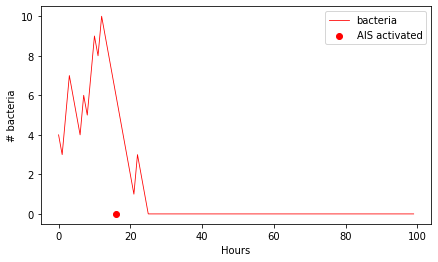

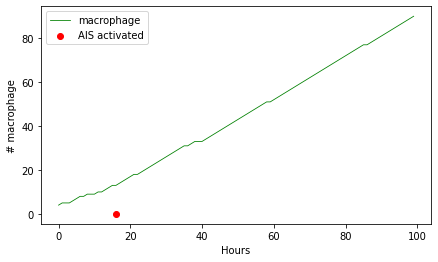

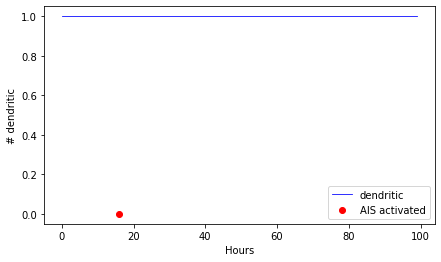

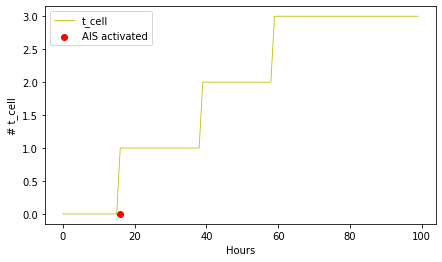

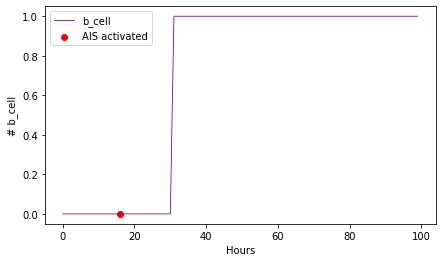

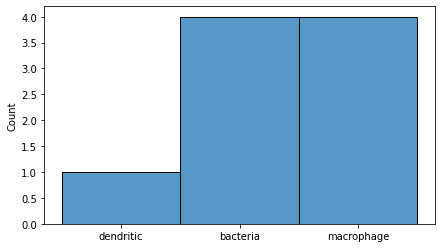

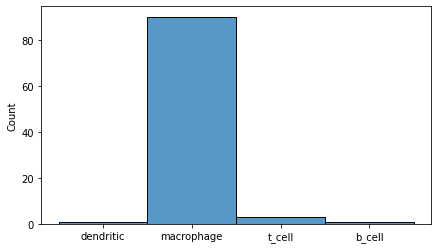

Case: Bacteria was killed
Max number of bacteria at some point : 10.0
Max number of macrophage at some point : 90.0
Max number of dendritic at some point : 1.0
Max number of t_cell at some point : 3.0
Max number of b_cell at some point : 1.0
Max ratio bacteria/macrophage 1.4 at t=2 no. bacteria 7.0 no. macrophage 5.0
Bacteria killed by macrophage:  277
Bacteria killed by dendritic:  3
Number ot times AIS was called:  1


In [6]:
get_ipython().magic('matplotlib inline')

# parameters
delay_ads = 1  # set the number of turns that takes to bring the adaptive inmmune system
m = 1  # m t-cell will be realeased once adaptive system is activated
n_ = 1 # kill n bacteria / add n macrophage cells wehn t-cell is called
bf = 2 # bacterium factor: number of bacteria multiplicity

# create an instance of the initial state of the system
init_state_bacteria = init_state(lambda_ = 3)

# simulate the process
Ts, states, infection = simulate(init_state_bacteria, BacteriaInfection, m, n_, bf, delay_ads, T=100)
 
# name of the experiment
exp_name="baseline"

# plot behavior of each cell of time 
plot_cell(Ts, states, infection, "bacteria", "red", exp_name, fig_dir)
plot_cell(Ts, states, infection, "macrophage", "green", exp_name, fig_dir)
plot_cell(Ts, states, infection, "dendritic", "blue", exp_name, fig_dir)
plot_cell(Ts, states, infection, "t_cell", "y", exp_name, fig_dir)
plot_cell(Ts, states, infection, "b_cell", "purple", exp_name, fig_dir)
plot_state(infection.init_state, exp_name, "init", fig_dir)
plot_state(infection.state, exp_name, "end", fig_dir)

# getting some statistics
get_statistics(infection, states)

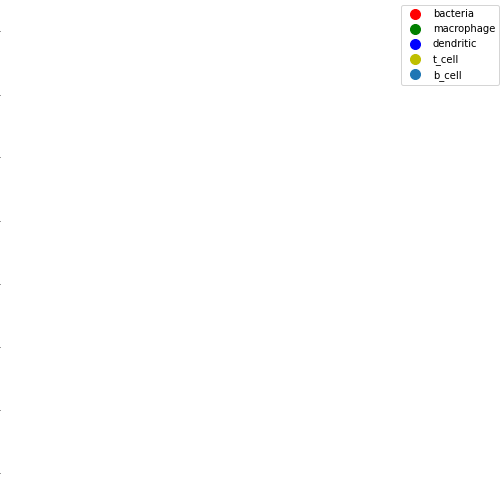

In [7]:
get_ipython().magic('matplotlib widget') 
anim =run_animation(states, infection.AIS_ts, interval=100)  

In [8]:
# save animation
writergif = PillowWriter(fps=100)
anim.save("./animation.gif", dpi=100, writer=writergif)

Max number of bacteria at some point : 34.84 	Std: 53.74992465110998
Max number of macrophage at some point : 76.7 	Std: 29.442656130179557
Max number of dendritic at some point : 1.0 	Std: 0.0
Max number of t_cell at some point : 2.56 	Std: 1.5576905982896603
Max number of b_cell at some point : 3.41 	Std: 2.839348516825647
Max ratio bacteria/macrophage 1.0 at t=0 no. bacteria 4.0 no. macrophage 4.0
Bacteria killed by macrophage:  342.82 	Std: 289.7125257906534
Bacteria killed by dendritic:  2.56 	Std: 1.5576905982896603
Number ot times AIS was called:  1.08 	Std: 1.0740577265678042


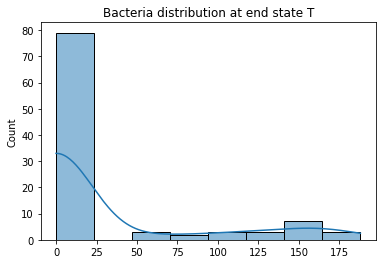

In [9]:
get_ipython().magic('matplotlib inline')

# run n=100 simulations
n = 100
Ts, states = simulate_n(n, init_state_bacteria, BacteriaInfection, m, n_, bf, delay_ads, T=100)

gif_dir = fig_dir + '/gif_{}/'.format(exp_name)
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)
        
# plot trajectories of the bacterial infection and get a gif
plot_simulated_trajectories(Ts, states, cell_type="bacteria", exp_name=exp_name, fig_dir=gif_dir)
draw_gif("baseline.gif", gif_dir, '*.png')

# plot stationary distribution
sns.histplot(states['bacteria'][:,-1], kde=True)
plt.title('Bacteria distribution at end state T')
plt.savefig(fig_dir + '/{}_simulate.jpg'.format(exp_name), bbox_inches='tight')

# get stats
get_mean_stats(states)

In [10]:
end_state_bacteria = states['bacteria'][:,-1]

# compute the probability that the immune system will win under these conditions
probability = (len(end_state_bacteria) - np.count_nonzero(end_state_bacteria))/n
probability

0.78

## 1.2 A more realistic approach 

A more realistic approach involves taking into account the time it takes for the adaptive system to response once it has been called by the innate system. 
For this reason, I created the following function that run all the experiment for the given parameters. 

In [11]:
def run_experiment(n, init_state, model, m =1, n_ =1, bf=2, delay_ads=1, T=100, exp_name="default", fig_dir="./images", show=False): 
    """A more complete function than run_simulations(n, init_state, model, m, n_, bf, delay_ads, T, exp_name, fig_dir=None)
    This runs the experiment and provide the statistics to document the results 
    
    n: number of Monte Carlo simulations
    init_state: the initial state of the bacteria and innate system (number of turns that takes to bring the adaptive inmmune system)
    model: the object for the bacteria model 
    m: number of t-cells that will be realeased once adaptive system is activated
    n: kill n bacteria / add n macrophage cells when t-cell is called
    bf : bacterium factor: number of bacteria multiplicity
    delay_ads: adaptive immune systems' response time
    T : time horizone
    """
    
    get_ipython().magic('matplotlib inline')
    print("Running experiment for delay_ads={}". format(delay_ads))
    #----------------- Run one single evolution of the bacteria in [0,T]-------------------------------#
    
    # simulate the process
    Ts, states, infection = simulate(init_state_bacteria, BacteriaInfection, m, n_, bf, delay_ads, T=100)

    # plot behavior of each cell of time 
    plot_cell(Ts, states, infection, "bacteria", "red", exp_name, fig_dir, show)
    plot_cell(Ts, states, infection, "macrophage", "green", exp_name, fig_dir, show)
    plot_cell(Ts, states, infection, "dendritic", "blue", exp_name, fig_dir, show)
    plot_cell(Ts, states, infection, "t_cell", "y", exp_name, fig_dir, show)
    plot_cell(Ts, states, infection, "b_cell", "purple", exp_name, fig_dir, show)
    plot_state(infection.init_state, exp_name, "init", fig_dir, show)
    plot_state(infection.state, exp_name, "end", fig_dir, show)

    # getting some statistics
    get_statistics(infection, states)
    
    # run animation 
    get_ipython().magic('matplotlib widget') 
    anim =run_animation(states, infection.AIS_ts, interval=100)  
    
    # save animation
    writergif = PillowWriter(fps=100)
    anim.save("./animation_{}.gif".format(exp_name), dpi=100, writer=writergif)
    
    #----------------- Run n simulations of the evolution of the bacteria in [0,T]-------------------------------#
    get_ipython().magic('matplotlib inline')

    Ts, states = simulate_n(n, init_state_bacteria, BacteriaInfection, m, n_, bf, delay_ads, T=100)
    
    gif_dir = fig_dir + '/gif_{}/'.format(exp_name)
    if not os.path.exists(gif_dir):
        os.makedirs(gif_dir)
          
    # plot trajectories of the bacterial infection and get a gif
    plot_simulated_trajectories(Ts, states, cell_type="bacteria", exp_name=exp_name, fig_dir=gif_dir, show=show)
    
    
    draw_gif("{}.gif".format(exp_name), gif_dir, '*.png')

    # plot stationary distribution
    sns.histplot(states['bacteria'][:,-1], kde=True)
    plt.title('Bacteria distribution at end state T')
    plt.savefig(fig_dir + '/{}_simulate.jpg'.format(exp_name), bbox_inches='tight')
    if show: 
        plt.show()
    else: 
        plt.close()
    # get stats
    get_mean_stats(states)
    
    end_state_bacteria = states['bacteria'][:,-1]

    # compute the probability that the immune system will win under these conditions
    probability = (len(end_state_bacteria) - np.count_nonzero(end_state_bacteria))/n
    print("Proability of winning immune system: ", probability) 

# Run models

Here, we can explore several properties

## Checking the relevance of the time to activate the adaptive immune system

Running experiment for delay_ads=1
Case: Bacteria was killed
Max number of bacteria at some point : 3.0
Max number of macrophage at some point : 83.0
Max number of dendritic at some point : 1.0
Max number of t_cell at some point : 10.0
Max number of b_cell at some point : 16.0
Max ratio bacteria/macrophage 1.0 at t=-1 no. bacteria 3.0 no. macrophage 3.0
Bacteria killed by macrophage:  1018
Bacteria killed by dendritic:  10
Number ot times AIS was called:  1


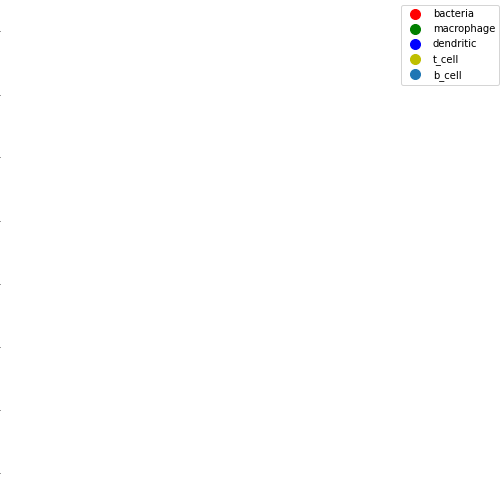

Max number of bacteria at some point : 33.62 	Std: 55.82916442147419
Max number of macrophage at some point : 74.54 	Std: 29.987137242491155
Max number of dendritic at some point : 1.0 	Std: 0.0
Max number of t_cell at some point : 3.13 	Std: 1.5469647701224487
Max number of b_cell at some point : 4.78 	Std: 3.8744806103528253
Max ratio bacteria/macrophage 1.0 at t=0 no. bacteria 3.0 no. macrophage 3.0
Bacteria killed by macrophage:  434.56 	Std: 343.8890321019267
Bacteria killed by dendritic:  3.13 	Std: 1.5469647701224487
Number ot times AIS was called:  1.24 	Std: 1.2815615474880635
Proability of winning immune system:  0.82
Running experiment for delay_ads=5
Case: Bacteria was killed
Max number of bacteria at some point : 4.0
Max number of macrophage at some point : 92.0
Max number of dendritic at some point : 1.0
Max number of t_cell at some point : 4.0
Max number of b_cell at some point : 4.0
Max ratio bacteria/macrophage 1.0 at t=-1 no. bacteria 3.0 no. macrophage 3.0
Bacteria k

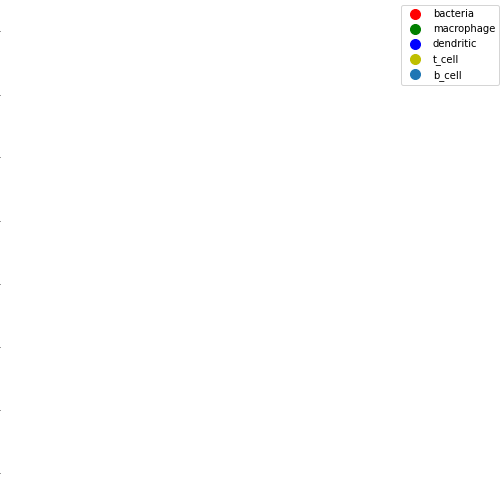

Max number of bacteria at some point : 42.1 	Std: 61.55720916350903
Max number of macrophage at some point : 71.99 	Std: 33.348311801349105
Max number of dendritic at some point : 1.0 	Std: 0.0
Max number of t_cell at some point : 2.41 	Std: 1.6376507564190848
Max number of b_cell at some point : 3.06 	Std: 2.855941175864797
Max ratio bacteria/macrophage 1.0 at t=0 no. bacteria 3.0 no. macrophage 3.0
Bacteria killed by macrophage:  290.48 	Std: 262.21519711870246
Bacteria killed by dendritic:  3.01 	Std: 2.220337812135802
Number ot times AIS was called:  1.06 	Std: 1.0278132126023678
Proability of winning immune system:  0.73
Running experiment for delay_ads=10
Bacteria was not killed
Number of bacteria 29
Max number of bacteria at some point : 37.0
Max number of macrophage at some point : 54.0
Max number of dendritic at some point : 1.0
Max number of t_cell at some point : 2.0
Max number of b_cell at some point : 2.0
Max ratio bacteria/macrophage 2.3333333333333335 at t=1 no. bacteria

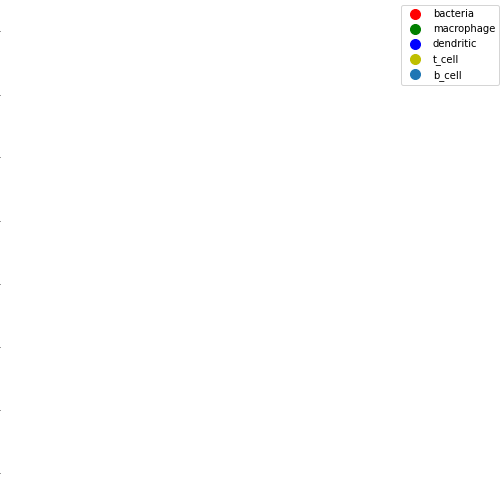

Max number of bacteria at some point : 35.4 	Std: 55.35738433127056
Max number of macrophage at some point : 75.11 	Std: 32.883702650401155
Max number of dendritic at some point : 1.0 	Std: 0.0
Max number of t_cell at some point : 2.13 	Std: 1.1632282665066216
Max number of b_cell at some point : 2.15 	Std: 1.8567444627627139
Max ratio bacteria/macrophage 1.0 at t=0 no. bacteria 3.0 no. macrophage 3.0
Bacteria killed by macrophage:  207.59 	Std: 178.1976484132156
Bacteria killed by dendritic:  3.02 	Std: 1.7943243853885504
Number ot times AIS was called:  1.18 	Std: 1.2835887191776032
Proability of winning immune system:  0.74
Running experiment for delay_ads=15
Case: Bacteria was killed
Max number of bacteria at some point : 3.0
Max number of macrophage at some point : 99.0
Max number of dendritic at some point : 1.0
Max number of t_cell at some point : 2.0
Max number of b_cell at some point : 4.0
Max ratio bacteria/macrophage 1.0 at t=-1 no. bacteria 3.0 no. macrophage 3.0
Bacteria k

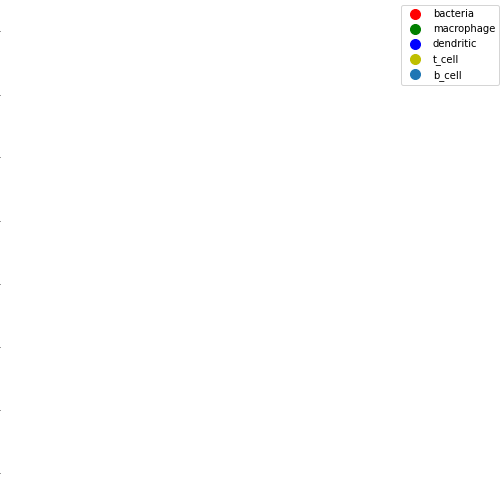

Max number of bacteria at some point : 60.46 	Std: 71.23768946281174
Max number of macrophage at some point : 64.21 	Std: 38.366729076114886
Max number of dendritic at some point : 1.0 	Std: 0.0
Max number of t_cell at some point : 1.68 	Std: 0.9368030742904296
Max number of b_cell at some point : 1.48 	Std: 1.5967466924969658
Max ratio bacteria/macrophage 1.0146198830409356 at t=1 no. bacteria 3.47 no. macrophage 3.42
Bacteria killed by macrophage:  123.31 	Std: 114.02391810493096
Bacteria killed by dendritic:  2.76 	Std: 1.8927229062913569
Number ot times AIS was called:  1.21 	Std: 1.2107435731813734
Proability of winning immune system:  0.6
Running experiment for delay_ads=20
Bacteria was not killed
Number of bacteria 174
Max number of bacteria at some point : 174.0
Max number of macrophage at some point : 9.0
Max number of dendritic at some point : 1.0
Max number of t_cell at some point : 2.0
Max number of b_cell at some point : 0.0
Max ratio bacteria/macrophage 19.333333333333332

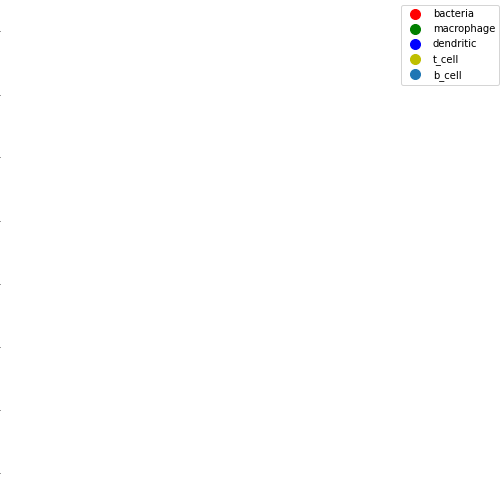

Max number of bacteria at some point : 58.9 	Std: 72.17222457427788
Max number of macrophage at some point : 65.45 	Std: 37.850594447115355
Max number of dendritic at some point : 1.0 	Std: 0.0
Max number of t_cell at some point : 1.43 	Std: 0.8972736483370054
Max number of b_cell at some point : 1.35 	Std: 1.499166435056495
Max ratio bacteria/macrophage 1.0 at t=0 no. bacteria 3.0 no. macrophage 3.0
Bacteria killed by macrophage:  127.85 	Std: 113.30404891264918
Bacteria killed by dendritic:  2.81 	Std: 2.081802103947443
Number ot times AIS was called:  1.2 	Std: 1.224744871391589
Proability of winning immune system:  0.63
Running experiment for delay_ads=25
Case: Bacteria was killed
Max number of bacteria at some point : 3.0
Max number of macrophage at some point : 100.0
Max number of dendritic at some point : 1.0
Max number of t_cell at some point : 1.0
Max number of b_cell at some point : 0.0
Max ratio bacteria/macrophage 1.0 at t=-1 no. bacteria 3.0 no. macrophage 3.0
Bacteria kil

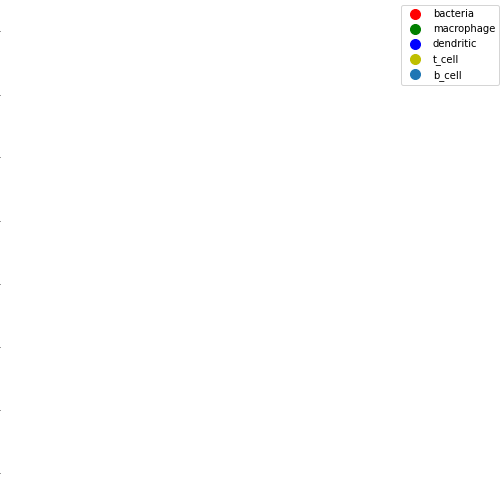

Max number of bacteria at some point : 55.91 	Std: 68.18842937038511
Max number of macrophage at some point : 66.32 	Std: 37.903794005349916
Max number of dendritic at some point : 1.0 	Std: 0.0
Max number of t_cell at some point : 1.45 	Std: 0.7399324293474372
Max number of b_cell at some point : 1.02 	Std: 1.1311940593903418
Max ratio bacteria/macrophage 1.0 at t=0 no. bacteria 3.0 no. macrophage 3.0
Bacteria killed by macrophage:  94.8 	Std: 74.29724086397825
Bacteria killed by dendritic:  2.96 	Std: 1.9945926902503177
Number ot times AIS was called:  1.15 	Std: 1.299038105676658
Proability of winning immune system:  0.63
Running experiment for delay_ads=30
Case: Bacteria was killed
Max number of bacteria at some point : 5.0
Max number of macrophage at some point : 99.0
Max number of dendritic at some point : 1.0
Max number of t_cell at some point : 1.0
Max number of b_cell at some point : 1.0
Max ratio bacteria/macrophage 1.6666666666666667 at t=0 no. bacteria 5.0 no. macrophage 3.

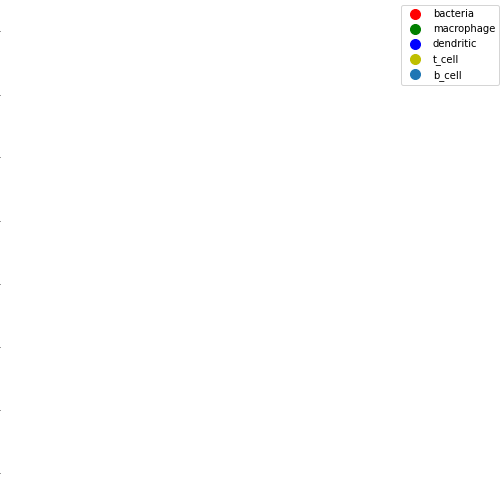

Max number of bacteria at some point : 55.46 	Std: 69.26231587234143
Max number of macrophage at some point : 66.81 	Std: 37.57570890881501
Max number of dendritic at some point : 1.0 	Std: 0.0
Max number of t_cell at some point : 1.34 	Std: 0.6814690014960328
Max number of b_cell at some point : 1.03 	Std: 1.187055179846329
Max ratio bacteria/macrophage 1.0 at t=0 no. bacteria 3.0 no. macrophage 3.0
Bacteria killed by macrophage:  95.75 	Std: 75.14444423907865
Bacteria killed by dendritic:  3.17 	Std: 2.1403504385964465
Number ot times AIS was called:  1.49 	Std: 1.584266391740985
Proability of winning immune system:  0.62


In [12]:
# fix parameters 
n=100
T=100

# create an instance of the initial state of the system
# init_state_bacteria = init_state(lambda_ = 3)

# number of simulations
ts_ads = [1, 5, 10, 15, 20, 25,30]

# create an instance of the initial state of the system
init_state_bacteria = init_state(lambda_ = 3)

for ts in ts_ads: 
    run_experiment(n, init_state_bacteria, BacteriaInfection, m =1, n_ =1, bf=2, delay_ads=ts, T=100, exp_name="t_delay_{}".format(ts), fig_dir="./images")

**Weak Immune system**

Here, we hypothesize that a weak immune system should have a long delay response from the adaptive system. It must remove miniminal amount of bacteria (n=1) and add a few macrophages (m=1). 

## Strong Immune system

We fixed the time response from the adaptive system to be 10 and explore with different values for m and n. The amount of bacteria (n=1) and macrophages added (m=1). 

In [11]:
n=1000
T=100

# create an instance of the initial state of the system
# init_state_bacteria = init_state(lambda_ = 3)

# number of simulations
ms = [1, 2, 4, 5, 10, 20]

print('M analysis')
for m in ms: 
    paths = run_simulations_no_plots(n, init_state_bacteria, BacteriaInfection, m=m, n_=1, bf=2, delay_ads=10, T=100)
    print((len(paths) - np.count_nonzero(paths))/n)

print('N analysis')
# number of simulations
ns = [1, 2, 4, 5, 10, 20]

for n_ in ns: 
    paths = run_simulations_no_plots(n, init_state_bacteria, BacteriaInfection, m=1, n_=n_, bf=2, delay_ads=10, T=10)
    print((len(paths) - np.count_nonzero(paths))/n)

M analysis
0.68
0.85
0.974
0.981
0.994
0.996
N analysis
0.361
0.67
0.894
0.917
0.96
0.98


We observed that a strong immune system should have a high $m$, and $n$. Does this keep the same when the multiplicity factor of bacteria increases?


In [25]:
n=1000
T=100

# create an instance of the initial state of the system
# init_state_bacteria = init_state(lambda_ = 3)

# number of simulations
# ms = [1, 2, 4, 5, 10, 20]

print('M=5, N=5 analysis')
# for m in ms: 
paths = run_simulations_no_plots(n, init_state_bacteria, BacteriaInfection, m=5, n_=5, bf=2, delay_ads=10, T=100)
print((len(paths) - np.count_nonzero(paths))/n)


bfs = [1, 2, 4, 5, 10, 20]

print('BF analysis')
for bf in bfs: 
    paths = run_simulations_no_plots(n, init_state_bacteria, BacteriaInfection, m=5, n_=5, bf=bf, delay_ads=10, T=100)
    print((len(paths) - np.count_nonzero(paths))/n)
    
    
print('BF analysis')
for bf in bfs: 
    paths = run_simulations_no_plots(n, init_state_bacteria, BacteriaInfection, m=5, n_=5, bf=bf, delay_ads=1, T=100)
    print((len(paths) - np.count_nonzero(paths))/n)
    

M=5, N=5 analysis
0.988
BF analysis
1.0
0.988
0.874
0.818
0.672
0.595
BF analysis
1.0
0.993
0.901
0.834
0.642
0.63


We observed that both the immune system is more weak agaisnt more agressive bacteria infection!

# Extra: Images for report

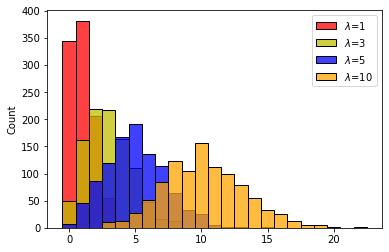

In [112]:
get_ipython().magic('matplotlib inline')

lambdas = [1,3,5,10]
colors = ['r', 'y', 'b', 'orange']

for i, lamba_ in enumerate(lambdas):
    samples = np.random.poisson(lamba_, 1000)
    sns.histplot(samples, discrete=True, color=colors[i], label="$\lambda$={}".format(lamba_))

plt.legend()
plt.savefig(fig_dir + '/poisson.jpg', bbox_inches='tight')

<AxesSubplot:ylabel='Count'>

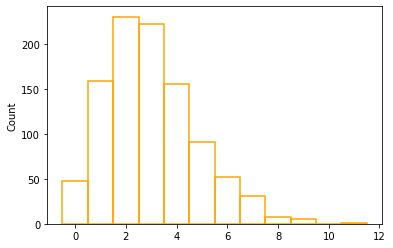

In [109]:
samples = np.random.poisson(3, 1000)
sns.histplot(samples, discrete=True, color=colors[i], label="$\lambda$={}".format(lamba_), fill=False)